In [19]:
%pylab inline
from scipy.interpolate import interp1d
import emcee
import triangle
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Constants

z = 0.029836
c = 299792.458

In [3]:
#Functions

def model_to_data_interp(x_m, y_m, x_d):
    
    f = interp1d(x_m, y_m, kind="linear")
    x_m_new = x_d
    y_m_new = f(x_d)
    
    return x_m_new, y_m_new


def normalization(y_d, y_m):
    
    obs_int = sum(y_d)
    teo_int = sum(y_m)
    y_m = y_m*obs_int/teo_int
    
    return y_m


def model(logtau, vmax, theta, logT, voff, x_d, y_d):
    
    os.system( ('./analytic_solution.x %f %f %f > "./model.dat"')%(10.0**logtau, vmax, theta) )
    
    mod = loadtxt('./model.dat')
    
    x_m_i = mod[:,0]
    y_m_i = mod[:,1]
    
    v_th = 12.85*sqrt((10.0**logT)/(10.0**4.0))
    x_m_i = x_m_i*v_th + voff
    
    x_m, y_m = model_to_data_interp(x_m_i, y_m_i, x_d) 
    
    y_m = normalization(y_d, y_m)
    
    return x_m, y_m

In [4]:
#Observed data

lars = loadtxt('./LARS02.txt')

x_data = lars[:-17,0] - c*z
y_data = lars[:-17,1]

#First guess

logtau_0 = 5
vmax_0 = 50
theta_0 = 45
logT_0 = 4
voff_0 = -11

x_0, y_0 = model(logtau_0, vmax_0, theta_0, logT_0, voff_0, x_data, y_data)

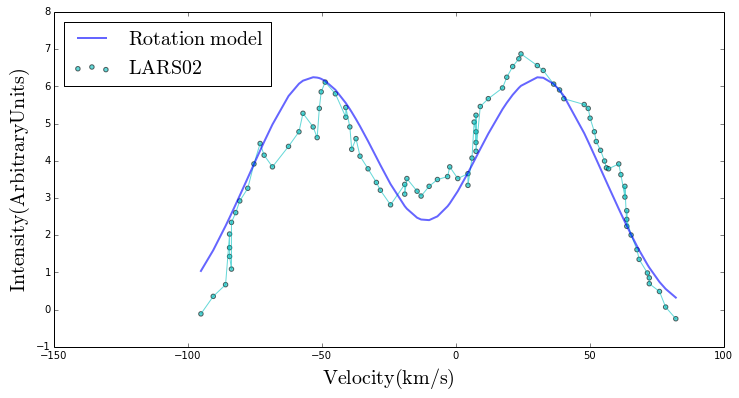

In [5]:
#Plot

fig = figure(figsize=(12,6))

scatter(x_data, y_data, c='c', alpha=0.6, label='$\mathrm{LARS 02}$')
plot(x_data, y_data, c='c', alpha=0.6)
plot(x_0, y_0, c='b', alpha=0.6, label='$\mathrm{Rotation\ model}$', lw=2)

xlabel('$\mathrm{Velocity (km/s)}$', fontsize=20)
ylabel('$\mathrm{Intensity (Arbitrary Units)}$', fontsize=20)
legend(loc='best', fontsize=20)

In [6]:
def lnprior(param):
    
    logtau, vmax, theta, logT, voff = param
    
    if 4 < logtau < 6 and 0 < vmax < 100 and 0 < theta < 90 and 4 < logT < 4.5 and -20 < voff < 20:
        return 0.0
    
    return -inf


def lnlike(param, x_d, y_d):
    
    logtau, vmax, theta, logT, voff = param
    
    x_m, y_m = model(logtau, vmax, theta, logT, voff, x_d, y_d)
    
    chi_squared = (1.0/2.0)*sum((y_d-y_m)**2)
    
    return -chi_squared


def lnprob(param, x_d, y_d):
    
    lp = lnprior(param)
    if not isfinite(lp):
        return -inf
    
    return lp + lnlike(param, x_d, y_d)

In [9]:
#Running emcee

ndim = 5
nwalkers = 12
nsteps = 2

first_guess = [logtau_0, vmax_0, theta_0, logT_0, voff_0]

pos = [first_guess+ 1e-3*random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_data, y_data))

print("Running MCMC...")
sampler.run_mcmc(pos, nsteps, rstate0=random.get_state())
print("Done!")

Running MCMC...
Done!


/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python2.7/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


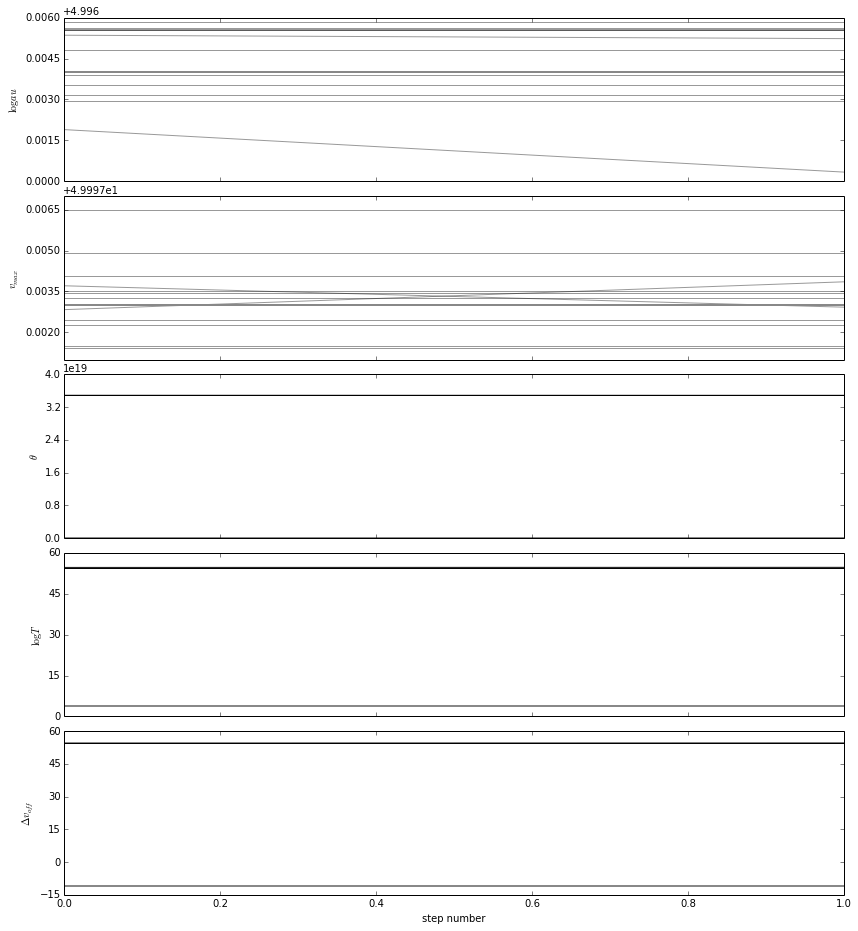

In [15]:
clf()

fig, axes = subplots(5, 1, sharex=True, figsize=(12, 13))

axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(logtau_0, color="#888888", lw=2)
axes[0].set_ylabel("$\log{\tau}$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(vmax_0, color="#888888", lw=2)
axes[1].set_ylabel("$v_{max}$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(theta_0, color="#888888", lw=2)
axes[2].set_ylabel(r"$\theta$")

axes[3].plot(np.exp(sampler.chain[:, :, 3]).T, color="k", alpha=0.4)
axes[3].yaxis.set_major_locator(MaxNLocator(5))
axes[3].axhline(logT_0, color="#888888", lw=2)
axes[3].set_ylabel("$\log{T}$")

axes[4].plot(np.exp(sampler.chain[:, :, 3]).T, color="k", alpha=0.4)
axes[4].yaxis.set_major_locator(MaxNLocator(5))
axes[4].axhline(voff_0, color="#888888", lw=2)
axes[4].set_ylabel("$\Delta v_{off}$")
axes[4].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)

In [24]:
print("Mean acceptance fraction: {0:.3f}"
                .format(mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.250


In [35]:
samples = sampler.chain

print(shape(samples))

(12, 2, 5)


In [36]:
fig = triangle.corner(samples, labels=["$\log{\tau}$", "$v_{max}$", r"$\theta$", "$\log{T}$", "$\Delta v_{off}$"],
                      truths=[logtau_0, vmax_0, theta_0, logT_0, voff_0])

AssertionError: The input sample array must be 1- or 2-D.

https://github.com/dfm/emcee/blob/master/examples/line.py

http://dan.iel.fm/emcee/current/user/line/